# Transfer learning with Tensorflow Part 1: Feature Extraction
Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.
Trere are two main benefits:
 1. Can leverage an existing neural network architecture to proven to work on problems similar to our own
 2. Can leverage a working neural network architecture which has already learned patterns on similar data those patterns to our own data

In [ ]:
# Are you using a GPU?
!nvidia-smi

Wed Aug  3 09:42:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   8966MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the download file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-03 09:42:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   267MB/s    in 0.6s    

2022-08-03 09:42:05 (267 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

#Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

There are 2 directories and 0 images in 10_food_classes_10_percent 
There are 10 directories and 0 images in 10_food_classes_10_percent/train 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings 
There are

## Creating data loaders (preparing the data)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size= IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
test_data_10_percent = train_datagen.flow_from_directory(test_dir,
                                                          target_size= IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfit) with the EarlyStopping callback

In [ ]:
#Create TensorBoard callback 
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)
  print(f"Saving TensorBoard log files to: {log_dir} ")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [ ]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes = 10):
  #Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, 
                                           name="feature_extraction_layers",
                                           input_shape = IMAGE_SHAPE+(3,))
  #Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])
  return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
#Create Resnet model 
resnet_model = create_model(resnet_url, num_classes=test_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layers (  (None, 2048)             23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220803-094209 
Epoch 1/5
24/24 [==============================] - 20s 702ms/step - loss: 1.8422 - accuracy: 0.3947 - val_loss: 1.1392 - val_accuracy: 0.6424
Epoch 2/5
24/24 [==============================] - 17s 709ms/step - loss: 0.8675 - accuracy: 0.7413 - val_loss: 0.8194 - val_accuracy: 0.7392
Epoch 3/5
24/24 [==============================] - 16s 677ms/step - loss: 0.5978 - accuracy: 0.8333 - val_loss: 0.7323 - val_accuracy: 0.7656
Epoch 4/5
24/24 [==============================] - 16s 679ms/step - loss: 0.4721 - accuracy: 0.8760 - val_loss: 0.7076 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 16s 682ms/step - loss: 0.3705 - accuracy: 0.9173 - val_loss: 0.6669 - val_accuracy: 0.7824


In [ ]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

#Plot the validation and trainig curve separately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))


  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()


  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

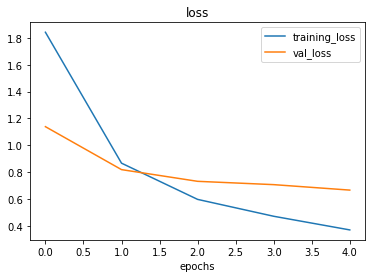

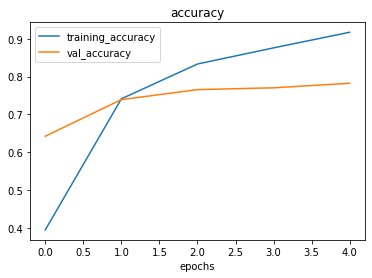

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model




In [ ]:
#Create EfficientNetB0 model 
efficientnet_model = create_model(efficientnet_url, num_classes=test_data_10_percent.num_classes)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layers (  (None, 1280)             4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Compile our resnet model
efficientnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220803-094337 
Epoch 1/5
24/24 [==============================] - 19s 671ms/step - loss: 1.8969 - accuracy: 0.4173 - val_loss: 1.3314 - val_accuracy: 0.7244
Epoch 2/5
24/24 [==============================] - 15s 641ms/step - loss: 1.0913 - accuracy: 0.7733 - val_loss: 0.8808 - val_accuracy: 0.8220
Epoch 3/5
24/24 [==============================] - 15s 637ms/step - loss: 0.7706 - accuracy: 0.8293 - val_loss: 0.7055 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 15s 638ms/step - loss: 0.6200 - accuracy: 0.8560 - val_loss: 0.6141 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 15s 644ms/step - loss: 0.5208 - accuracy: 0.8827 - val_loss: 0.5630 - val_accuracy: 0.8640


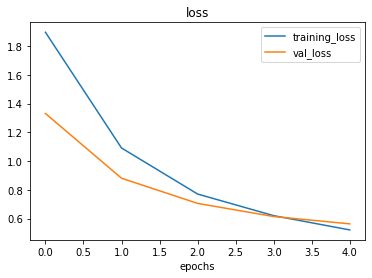

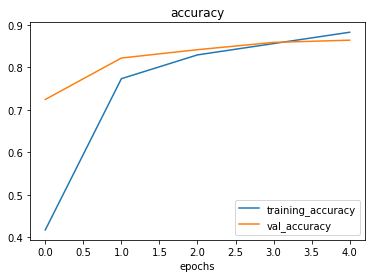

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes what so ever 
* "Feature extraction " transfer learning - use the prelearned patterns of an existing model and adjust the output layer for your own problem
* "Fine-tuning" transfer learning- use the prelearned patterns of an existing model and "fine-tune" may or all of underlying layers (including new output layers) 

## Comparing our models results using TensorBoard